In [0]:
import pandas as pd   
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import datetime

## 1. Today: More Pandas Practice and Concepts

1. Spotify data

2. Selecting and renaming data tables

3. Grouping and aggregating data

4. Merging dataframes

5. Working with time-series

## Spotify data:

In [2]:
!git clone https://<user>:<password>@github.com/haroldfox/ts-stuy-2019

Cloning into 'ts-stuy-2019'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 88 (delta 28), reused 29 (delta 3), pack-reused 0
Unpacking objects: 100% (88/88), done.


In [3]:
!ls ts-stuy-2019/datasets

movie_metadata.csv  song_artist.h5  song_date.h5  songs.h5


In [0]:
songs = pd.read_hdf('ts-stuy-2019/datasets/songs.h5')
song_date = pd.read_hdf('ts-stuy-2019/datasets/song_date.h5')
song_artist = pd.read_hdf('ts-stuy-2019/datasets/song_artist.h5')

Peak at datasets:


In [5]:
songs.head()

,Artist,ArtistLink,Song,SongLink
0,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html,rockstar,../track/7wGoVu4Dady5GV0Sv4UIsx.html
1,Lil Uzi Vert,../artist/4O15NlyKLIASxsJ0PrXPfz.html,XO TOUR Llif3,../track/7GX5flRQZVHRAGd6B4TmDO.html
2,Kendrick Lamar,../artist/2YZyLoL8N0Wb9xBt1NhZWg.html,HUMBLE.,../track/7KXjTSCq5nL1LoYtL7XAwS.html
3,Drake,../artist/3TVXtAsR1Inumwj472S9r4.html,God's Plan,../track/2XW4DbS6NddZxRPm5rMCeY.html
4,Drake,../artist/3TVXtAsR1Inumwj472S9r4.html,One Dance,../track/1xznGGDReH1oQq0xzbwXa3.html


In [6]:
songs[songs['Song'] == 'Sober']

,Artist,ArtistLink,Song,SongLink
1405,G-Eazy,../artist/02kJSzxNuaWGqwubyUba0Z.html,Sober,../track/3qk4wRMDlaeagZGjSYbsOV.html
1763,Demi Lovato,../artist/6S2OmqARrzebs0tKUEyXyp.html,Sober,../track/0STK94RxUulYqWzwFlyAb5.html
1902,Childish Gambino,../artist/73sIBHcqh3Z3NyqHKZ7FOL.html,Sober,../track/6olUplztLFFfU7fMYmFXOP.html
2591,Lorde,../artist/163tK9Wjr9P9DmM0AVK7lm.html,Sober,../track/2mNbgyi0gori4b1rFSPgIb.html
2821,Selena Gomez,../artist/0C8ZW7ezQVs4URX5aX7Kqx.html,Sober,../track/3viZcRlE38APncWJ5VGM4q.html


In [7]:
song_date.head()

,Date,Streams,TrackUrl,Track
0,2017-09-21,17453592.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
1,2017-09-28,19553820.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
2,2017-10-05,18558660.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
3,2017-10-12,17366836.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
4,2017-10-19,18173497.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar


In [8]:
song_artist.head()

,Artist,ArtistLink,Track,TrackUrl
0,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html,rockstar,../track/7wGoVu4Dady5GV0Sv4UIsx.html
1,21 Savage,../artist/1URnnhqYAYcrqrcwql10ft.html,rockstar,../track/7wGoVu4Dady5GV0Sv4UIsx.html
0,Lil Uzi Vert,../artist/4O15NlyKLIASxsJ0PrXPfz.html,XO TOUR Llif3,../track/7GX5flRQZVHRAGd6B4TmDO.html
0,Kendrick Lamar,../artist/2YZyLoL8N0Wb9xBt1NhZWg.html,HUMBLE.,../track/7KXjTSCq5nL1LoYtL7XAwS.html
0,Drake,../artist/3TVXtAsR1Inumwj472S9r4.html,God's Plan,../track/2XW4DbS6NddZxRPm5rMCeY.html


number of rows

In [9]:
song_date.shape

(104812, 4)

In [10]:
songs.shape

(3987, 4)

max and min dates

In [11]:
song_date['Date'].min()

Timestamp('2013-04-28 00:00:00')

In [12]:
song_date['Date'].max()

Timestamp('2019-02-28 00:00:00')

data types

In [13]:
song_date['Date'].dtype

dtype('<M8[ns]')

## Selecting and renaming tables

Selecting columns







In [0]:
artists = song_artist[['Artist', 'ArtistLink']]

In [0]:
artists = artists.drop_duplicates()

In [17]:
artists.shape

(1246, 2)

Renaming columns (songs)

In [0]:
songs = songs.rename(columns={'Song': 'Track', 'SongLink': 'TrackUrl'})

Sort by column

In [19]:
song_date.sort_values('Streams', ascending=False).head()

,Date,Streams,TrackUrl,Track
2,2018-07-19,30747676.0,../track/2G7V7zsVDxg1yRsu7Ew9RJ.html,In My Feelings
1,2018-02-01,28708450.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
0,2019-01-24,28151388.0,../track/6ocbgoVGwYJhOv1GgI9NsF.html,7 rings
0,2018-01-25,26345370.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
0,2018-07-05,24972971.0,../track/0TlLq3lA83rQOYtrqBqSct.html,Nonstop


Drop duplicates (artists)

## Grouping and aggregating data

Aggregations: sum, count, mean, median, max, min, std







In [20]:
song_date['Streams'].sum()

100589707567.0

In [25]:
song_date['Streams'].mean()

1575628.633119782

Group-by aggregations: head, tail

In [26]:
song_date.groupby('Date', as_index=False)[['Streams']].sum()

,Date,Streams
0,2013-04-28,23253607.0
1,2013-05-05,23088156.0
2,2013-05-12,23048414.0
3,2013-05-19,22555044.0
4,2013-05-26,23672233.0
5,2013-06-02,21703959.0
6,2013-06-09,22204117.0
7,2013-06-16,21472971.0
8,2013-06-23,25489713.0
9,2013-06-30,25109367.0


Top songs

In [27]:
top_songs = song_date.groupby(['Track', 'TrackUrl'], as_index=False)[['Streams']].sum()
top_songs.sort_values('Streams', ascending=False).head(10)

,Track,TrackUrl,Streams
3960,rockstar,../track/7wGoVu4Dady5GV0Sv4UIsx.html,526568911.0
3819,XO TOUR Llif3,../track/7GX5flRQZVHRAGd6B4TmDO.html,500942651.0
1375,HUMBLE.,../track/7KXjTSCq5nL1LoYtL7XAwS.html,494041788.0
1314,God's Plan,../track/2XW4DbS6NddZxRPm5rMCeY.html,484983076.0
2457,One Dance,../track/1xznGGDReH1oQq0xzbwXa3.html,456343099.0
738,Congratulations,../track/3a1lNhkSLSkpJE4MSHpDu9.html,451833377.0
691,Closer,../track/7BKLCZ1jbUBVqRi2FVlTVw.html,404877134.0
2808,SAD!,../track/3ee8Jmje8o58CHK66QrVC2.html,383011211.0
3925,goosebumps,../track/6gBFPUFcJLzWGx4lenP6h2.html,359510103.0
1989,Location,../track/152lZdxL1OR0ZMW6KquMif.html,354114515.0


Top songs by date

In [28]:
top_by_date = song_date.sort_values(['Date', 'Streams'], ascending=(True, False)).groupby('Date').head(1)
top_by_date.tail(60)

,Date,Streams,TrackUrl,Track
16,2018-01-11,9855305.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
17,2018-01-18,9029173.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar
0,2018-01-25,26345370.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
1,2018-02-01,28708450.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
2,2018-02-08,24209854.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
3,2018-02-15,22071986.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
4,2018-02-22,23813466.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
5,2018-03-01,23327237.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
6,2018-03-08,20829362.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan
7,2018-03-15,18577161.0,../track/2XW4DbS6NddZxRPm5rMCeY.html,God's Plan


## Merging dataframes

Add artist-name to total plays



In [30]:
top_songs = pd.merge(top_songs, songs[['TrackUrl', 'Artist', 'ArtistLink']], on='TrackUrl')
top_songs.head()
song_date = pd.merge(song_date, songs[['TrackUrl', 'Artist', 'ArtistLink']], on='TrackUrl')
song_date.head()

,Date,Streams,TrackUrl,Track,Artist,ArtistLink
0,2017-09-21,17453592.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html
1,2017-09-28,19553820.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html
2,2017-10-05,18558660.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html
3,2017-10-12,17366836.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html
4,2017-10-19,18173497.0,../track/7wGoVu4Dady5GV0Sv4UIsx.html,rockstar,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html


Top artists

In [32]:
artists_by_date.head()

,Streams
0,17453592.0
1,19553820.0
2,18558660.0
3,17366836.0
4,18173497.0
5,17532665.0
6,16032786.0
7,15268097.0
8,14517200.0
9,14319785.0


In [34]:
artists_by_date = song_date.groupby(['Date', 'Artist', 'ArtistLink'], as_index=False)[['Streams']].sum()
top_artists = artists_by_date.sort_values(['Date', 'Streams'], ascending=(True, False)).groupby('Date').head(1)
top_artists.tail(60)

,Date,Artist,ArtistLink,Streams
42083,2018-01-11,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html,30606271.0
42171,2018-01-18,Camila Cabello,../artist/4nDoRrQiYLoBzwC5BhVJzF.html,31082632.0
42428,2018-01-25,Drake,../artist/3TVXtAsR1Inumwj472S9r4.html,41579098.0
42747,2018-02-01,Migos,../artist/6oMuImdp5ZcFhWP0ESe6mG.html,78699870.0
42972,2018-02-08,Migos,../artist/6oMuImdp5ZcFhWP0ESe6mG.html,42292398.0
43165,2018-02-15,Kendrick Lamar,../artist/2YZyLoL8N0Wb9xBt1NhZWg.html,34487417.0
43352,2018-02-22,Drake,../artist/3TVXtAsR1Inumwj472S9r4.html,32434467.0
43705,2018-03-01,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html,50891990.0
43945,2018-03-08,Post Malone,../artist/246dkjvS1zLTtiykXe5h60.html,41507560.0
44138,2018-03-15,Logic,../artist/4xRYI6VqpkE3UwrDrAZL8L.html,72930914.0


## Time-series

Plot streams by date

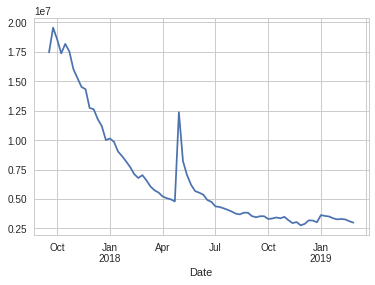

In [37]:
song_date[song_date['Track'] == 'rockstar'].set_index('Date')['Streams'].plot()

Pivot tables (show 3 songs)

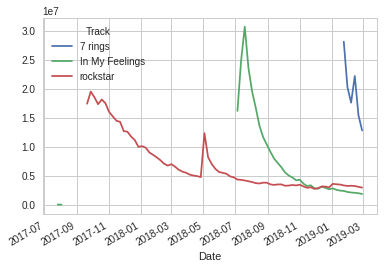

In [40]:
song_date[song_date['Track'].isin(['rockstar', '7 rings', 'In My Feelings'])].pivot('Date', 'Track', 'Streams').plot()

## Demo

Find all of the #1 songs by month for 2018 and plot their plays over time

In [41]:
song_date['Month'] = song_date['Date'].dt.to_period('M')
song_month = song_date.groupby(['Month', 'Track', 'TrackUrl'], as_index=False)[['Streams']].sum()
top_by_month = song_month.sort_values(['Month', 'Streams'], ascending=(True, False)).groupby('Month', as_index=False).head(1)
top_by_month.tail(60)

,Month,Track,TrackUrl,Streams
1275,2014-03,Happy,../track/5b88tNINg4Q4nrRbrCXUmg.html,11277348.0
1390,2014-04,Happy,../track/5b88tNINg4Q4nrRbrCXUmg.html,7546010.0
1501,2014-05,Fancy,../track/5GJwmgyFOO0kHhTkgQP2Sp.html,11915022.0
1612,2014-06,Fancy,../track/5GJwmgyFOO0kHhTkgQP2Sp.html,15454810.0
1787,2014-07,Rude,../track/6RtPijgfPKROxEzTHNRiDp.html,11309416.0
1931,2014-08,Stay With Me,../track/7IHOIqZUUInxjVkko181PB.html,13791965.0
1965,2014-09,All About That Bass,../track/1q676iYDR3GeJtOHdyggIU.html,13600059.0
2323,2014-10,Shake It Off,../track/7n9Q6bXSjm74uCtajkddPt.html,14142015.0
2765,2014-11,Take Me To Church,../track/7dS5EaCoMnN7DzlpT6aRn2.html,14339333.0
3195,2014-12,Take Me To Church,../track/7dS5EaCoMnN7DzlpT6aRn2.html,16185889.0


FInd the #1 artists by week

Total plays by week

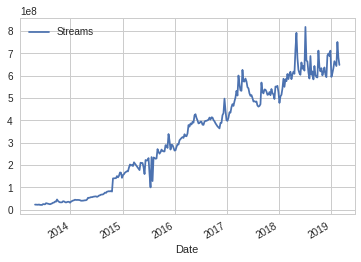

In [42]:
total_by_date = song_date.groupby('Date', as_index=False)[['Streams']].sum()
total_by_date.set_index('Date').plot()

## Exercises

1. Which hit song took the longest to peak? i.e. Which songs had the longest time between when they first appeared on the chart to when they reached their maximum level?



2. Which song peaked the quickest? That is, which song reached 80% of its total plays in the shortest amount of time? Exclude songs which debuted in the last 6 months

3. Which artist has the most and biggest collaborators? Score an artist by the total number of plays that they have for all songs. Then, calculate the sum of the scores for each artist's collaborators.


4. Plot # of streams by date. Is there seasonality? Is there a trend?

5. What is the biggest cluster of collaborators?


6. Who is the most central artist within this cluster?